<a href="https://colab.research.google.com/github/housemLassoued/ML-deployment/blob/main/Skin_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install -q kaggle

In [36]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"housemlassoued","key":"7b2ef306377a80351a69bb9bb21db2e7"}'}

In [37]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [38]:
!cp kaggle.json ~/.kaggle/

In [39]:
! chmod 600 ~/.kaggle/kaggle.json

In [40]:
! kaggle datasets download -d shashanks1202/skin-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/shashanks1202/skin-cancer-dataset
License(s): MIT
 80% 5.00M/6.29M [00:00<00:00, 32.7MB/s]
100% 6.29M/6.29M [00:00<00:00, 39.0MB/s]


In [41]:
!unzip skin-cancer-dataset.zip

Archive:  skin-cancer-dataset.zip
  inflating: train_cancer/benign/12.jpg  
  inflating: train_cancer/benign/13.jpg  
  inflating: train_cancer/benign/14.jpg  
  inflating: train_cancer/benign/17.jpg  
  inflating: train_cancer/benign/19.jpg  
  inflating: train_cancer/benign/20.jpg  
  inflating: train_cancer/benign/21.jpg  
  inflating: train_cancer/benign/22.jpg  
  inflating: train_cancer/benign/23.jpg  
  inflating: train_cancer/benign/24.jpg  
  inflating: train_cancer/benign/25.jpg  
  inflating: train_cancer/benign/26.jpg  
  inflating: train_cancer/benign/27.jpg  
  inflating: train_cancer/benign/28.jpg  
  inflating: train_cancer/benign/29.jpg  
  inflating: train_cancer/benign/3.jpg  
  inflating: train_cancer/benign/30.jpg  
  inflating: train_cancer/benign/32.jpg  
  inflating: train_cancer/benign/33.jpg  
  inflating: train_cancer/benign/34.jpg  
  inflating: train_cancer/benign/35.jpg  
  inflating: train_cancer/benign/36.jpg  
  inflating: train_cancer/benign/38.jpg  
 

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [43]:
train_cancer_benign_path = '/content/train_cancer/benign'
train_cancer_malignant_path = '/content/train_cancer/malignant'

In [44]:
import glob
train_cancer_benign_files = glob.glob(train_cancer_benign_path + '/*')
train_cancer_malignant_files = glob.glob(train_cancer_malignant_path + '/*')

In [45]:
train_cancer_benign_list=[]
train_cancer_malignant_list=[]
for i in train_cancer_benign_files:
  img=cv2.imread(i)
  img=cv2.resize(img,(224,224))
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  train_cancer_benign_list.append(img)
for i in train_cancer_malignant_files:
  img=cv2.imread(i)
  img=cv2.resize(img,(224,224))
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  train_cancer_malignant_list.append(img)


In [46]:
print(len(train_cancer_benign_list))
print(len(train_cancer_malignant_list))

30
240


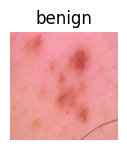

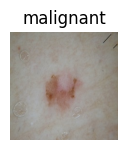

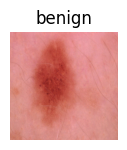

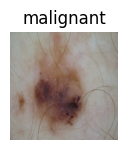

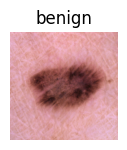

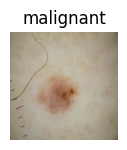

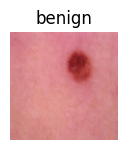

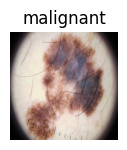

In [47]:
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(train_cancer_benign_list[i])
  plt.axis('off')
  plt.title('benign')
  plt.show()
  plt.subplot(1,4,i+1)
  plt.imshow(train_cancer_malignant_list[i])
  plt.axis('off')
  plt.title('malignant')
  plt.show()


In [48]:
import numpy as np

train_cancer_benign_list = np.array(train_cancer_benign_list)
train_cancer_malignant_list = np.array(train_cancer_malignant_list)

train_cancer_list = np.concatenate((train_cancer_benign_list, train_cancer_malignant_list), axis=0)
train_cancer_list.shape


(270, 224, 224, 3)

In [49]:
y_benign = np.zeros(len(train_cancer_benign_list))  # Labels for benign images
y_malignant = np.ones(len(train_cancer_malignant_list))  # Labels for malignant images
y = np.concatenate((y_benign, y_malignant), axis=0)

In [50]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(sampling_strategy='minority')
train_cancer_list,y=ros.fit_resample(train_cancer_list.reshape(-1,224*224*3),y)
train_cancer_list=train_cancer_list.reshape(-1,224,224,3)
train_cancer_list.shape,y.shape

((480, 224, 224, 3), (480,))

In [51]:
from sklearn.model_selection import train_test_split

x_train_val, x_test, y_train_val, y_test = train_test_split(train_cancer_list, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)
x_train.shape, x_val.shape, x_test.shape

((307, 224, 224, 3), (77, 224, 224, 3), (96, 224, 224, 3))

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    channel_shift_range=20
    )

val_generator = ImageDataGenerator(rescale=1./255)


test_generator = ImageDataGenerator(rescale=1./255)


In [53]:
train = train_generator.flow(x_train, y_train, batch_size=32,shuffle=True)
test = test_generator.flow(x_test, y_test, batch_size=32,shuffle=False)
val = val_generator.flow(x_val, y_val, batch_size=32,shuffle=False)

In [54]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train, epochs=20, validation_data=val, callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 227s 22s/step - accuracy: 0.5373 - loss: 1.6794 - val_accuracy: 0.5455 - val_loss: 1.1743
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 262s 26s/step - accuracy: 0.6732 - loss: 1.0892 - val_accuracy: 0.7792 - val_loss: 0.6430
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 235s 24s/step - accuracy: 0.6681 - loss: 0.9464 - val_accuracy: 0.8312 - val_loss: 0.4084
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 249s 22s/step - accuracy: 0.7658 - loss: 0.5591 - val_accuracy: 0.7922 - val_loss: 0.4021
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 221s 22s/step - accuracy: 0.8239 - loss: 0.3871 - val_accuracy: 0.8442 - val_loss: 0.3970
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 261s 22s/step - accuracy: 0.8327 - loss: 0.3806 - val_accuracy: 0.8442 - val_loss: 0.3663
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 257s 26s/step - accuracy: 0.7955 - loss: 0.4386 - val_accuracy: 0.8571 - val_loss: 0.3419
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 219s 22s/step - accuracy: 0.8188 - loss: 0.3823 - val_accuracy: 0.8442 - val_

In [56]:
accuracy = model.evaluate(test)
print('Test accuracy:', accuracy[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 18s/step - accuracy: 0.9896 - loss: 0.1033
Test accuracy: 0.9791666865348816


In [57]:
from sklearn.metrics import classification_report
y_pred = model.predict(test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 53s 18s/step
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        51
         1.0       1.00      0.96      0.98        45

    accuracy                           0.98        96
   macro avg       0.98      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96

